ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **05Mar21**

# 06. Poisson 1D with Dirichlet Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Plotting Functions](#plotting)
<br><br>
1. [Problem Statement](#problem)
 + [Strong Form](#dbcstrong)
 + [Variational Form](#dbcweak)
 + [Poisson-Dirichlet Energy](#energy)
<br><br>
1. [Problem Solution](#solution)
 + [MOOSE Application Development](#dbcapp)
 + [Code a Diffusion Term Kernel](#dbcdiff)
 + [Code a Source Term Kernel](#dbcsource)
 + [Compile and Link Application](#compile1)
 + [Input File](#dbcinput)
 + [Run Application](#dbcrun)
<br><br>   
1. [Linear Lagrange FEM Results](#dbclinearfemresults)
 + [Compute Error](#linearerror)
<br><br>    
1. [Quadratic Lagrange FEM Results](#dbcquadfemresults)
 + [Compute Error](#quaderror)
<br><br>    
1. [Diffusion Flux Postprocessing](#diffusionfluxpostpro)
 + [Auxiliary Variable](#auxvar)
 + [Use MOOSE Diffusion Flux Auxiliary Kernel](#auxdiffflux)
    - [Compute Error](#difffluxerror1)
 + [Code a Diffusion Flux Auxiliary Kernel](#auxdiffflux2)
 + [Compile and Link Application](#compile2)
    - [Compute Error](#difffluxerror2)
<br><br>   
1. [Energy Postprocessing](#energypostpro)
 + [Code the Energy Postprocessor](#postpro)
 + [Compile and Link Application](#compilelink2)
 + [Input File](#energyinput)
 + [Run Application](#runenergy)
 + [Energy Results](#energyresults)
    - [Compute Error](#energyerror)
<br><br>   
1. [Application Tree](#tree)
---

## [Objectives](#toc)<a id="obj"></a>

 + Begin using [`MOOSE`](https://mooseframework.inl.gov) to practice solving ODE's. Therefore access to a working [`MOOSE`](https://mooseframework.inl.gov) installation is necessary. Additional local information on installation for your computer setting can be found [here](https://github.com/UML-Linux-Club/moose-info).
 + Introduce the Galerkin variational (weak) form of the Poisson 1D problem below ([OneNote notes here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eib-vZHIpRlPlOMtz0Gf_asBegEFKsl9dOK4nHyDbgSeUA?e=sLu1td)).
 + Introduce the use of the boundary condition known as Dirichlet boundary condition.
 + Use second order accurate finite element Lagrange basis functions to solve the problem numerically.
 + <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. A significant effort in programing is often necessary to learn the subject well. However the material in this course is helpful with this task. Hands-on work during lectures will try to fill in existing gap. The steps in this notebook are necessary for a basic understanding of the subject.</span> 
 + You are supposed to consult the [`MOOSE source documentation`](https://mooseframework.inl.gov/source/index.html) to fill in gaps in reproducing the steps below.</span>

## [Plotting Functions](#toc)<a id="plotting"></a>

This is an auxiliary section for holding plotting functions used later.

In [1]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(14, 5))

    ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

    ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [g/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU_x' in df.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_x'],'*-', color='yellow', label=flux_basis_functions_type)

        ax2.set_ylabel(r"$q_h(x)$ [g/cm$^2$-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

In [2]:
'''Plot Function for Error Compared to Exact Dimensionless Solution'''

def plot_solution_error(df, title='Dimensionless FEM Solution and Error', fem_type='No FEM type'):
    
    from engy_5310.moose_toolkit import engy5310_p1_exact_solution

    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.style.use('dark_background')
    
    (u_hat, _, _) = engy5310_p1_exact_solution(x_a, x_b, u_a, u_b, diff_coeff, source_s)

    L = df['x'].max() - df['x'].min()
    x_mean = (df['x'].max() + df['x'].min())/2.0
    x_hat = (df['x'] - x_mean)/L
    a_hat = u_a/source_s*diff_coeff/L**2
    b_hat = u_b/source_s*diff_coeff/L**2

    uh_hat = df['u']/source_s*diff_coeff/L**2

    plt.figure(1, figsize=(14, 5))
    
    plt.plot(x_hat, uh_hat,'r-*',label=fem_type)
    
    plt.plot(x_hat, u_hat(x_hat, a_hat, b_hat), 'x', color='yellow', label='Exact Solution')

    plt.plot(x_hat, uh_hat-u_hat(x_hat, a_hat, b_hat), 'x', color='magenta', label=r'$\hat{u}_h-\hat{u}$')
    
    plt.title(label=title, fontsize=20)
    plt.ylabel(r'$\hat{u}_h, \hat{u}$', fontsize=18)
    plt.xlabel(r'$\hat{x}$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()

In [3]:
'''Plot Function for Error Compared to Exact Dimensionless Solution'''

def plot_flux_error(df, fem_type='No FEM type'):
    
    from engy_5310.moose_toolkit import engy5310_p1_exact_solution
        
    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.style.use('dark_background')
    
    (_, flux_hat, _) = engy5310_p1_exact_solution(x_a, x_b, u_a, u_b, diff_coeff, source_s)

    L = df['x'].max() - df['x'].min()
    x_mean = (df['x'].max() + df['x'].min())/2.0
    x_hat = (df['x'] - x_mean)/L
    
    a_hat = u_a/source_s*diff_coeff/L**2
    b_hat = u_b/source_s*diff_coeff/L**2

    flux_h_hat = df['diffFluxU_x']/source_s/L

    plt.figure(1, figsize=(14, 5))
    
    plt.plot(x_hat, flux_h_hat, 'r-*', label=fem_type)
    
    plt.plot(x_hat, flux_hat(x_hat, a_hat, b_hat), 'x', color='yellow', label='Exact Solution')

    plt.plot(x_hat, flux_h_hat-flux_hat(x_hat, a_hat, b_hat),'x',color='magenta',label=r'$\hat{q}_h-\hat{q}$')
    
    plt.title('Dimensionless FEM Solution and Error', fontsize=20)
    plt.ylabel(r'$\hat{q}_h, \hat{q}$', fontsize=18)
    plt.xlabel(r'$\hat{x}$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()

## [Problem Statement](#toc)<a id="problem"></a>

The following sections describe what is referred in the literature as the one-dimensional Poisson problem with Dirichlet boundary conditions.

### [Strong Form of Problem Statement](#toc)<a id="dbcstrong"></a>

Solve the Poisson model problem. Find $u:[a,b]\subset\Reals\rightarrow\Reals$ for $D > 0$ such that:

\begin{align*}
 -\bigl(-D\, u'\bigr)'(x) + S &= 0 \quad\quad \forall \quad\quad x\in [a,b], \\
 u(a) &= A, \\
 u(b) &= B.
\end{align*}
   
This problem has an analytical solution and you should obtain it for the constants: diffusion coefficient, $D$, source, $S$, entry concentration, $A$, and exit concentration $B$. The *diffusion flux* associated to the quantity $u$, is denoted $q := -D\,u'$, and it is often of interest as a derived quantity.

The values of the dependent variable are given on the two end points of the domain. This is called *essential* boundary conditions or  *Dirichlet boundary conditions*.

### [Variational Form of Problem Statement](#toc)<a id="dbcweak"></a>

The Galerkin variational formulation is as follows. Find $u \in H^1\!\bigl([a,b]\bigr)$ so that 

\begin{align*}
 \int\limits_a^b -D\, u'(x)\,v'(x)\,dx + \int\limits_a^b S\,v(x)\,dx &= 0 \quad\quad \forall \quad\quad v \in H^1_0\!\bigl([a,b]\bigr), 
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\subset\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty \bigr\}$ and 
$H^1_0\!\bigl([a,b]\bigr) := \bigl\{ v \mid v \in H^1(a,b), v(a) = 0, v(b) =0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $v$ is called a test function. Because $v$ and $u$ are sought in very similar sets of functions, this variational form is called Galerkin's variational form.

The two integrals in the variational formulation are the key terms to be computed. Since the MOOSE framework performs the integration, and provides the implementation of the test function, we need to provide the integrand of the integrals, that is, the kernels. Therefore the kernels needed are:

 1. $-D\, u'(x)\,v'(x)$ ,
 1. $S\,v(x)$.
 
The kernels are to be evaluated at quadrature points provided by the MOOSE framework.

### [Poisson-Dirichlet Energy](#toc)<a id="energy"></a>

It is of theoretical and practical importance to compute the associated energy that the variational form minimizes, that is the **Poisson-Dirichlet total energy**:

\begin{align*}
 \Phi[u] := \int\limits_a^b \,\frac{1}{2}\bigl(q(x)\bigr)^2 - D\,S\,u(x) \,dx.
\end{align*}

Since this is done after the solution is computed, it is characterized as a *postprocessing* operation. In `MOOSE` this is implemented in a *Postprocessors* class. First however, any derived quantity used in the integrand needs to be passed to the preprocessor for integration. Here we need to compute the local *flux*, $q$. In `MOOSE` this is done by creating an *auxiliary* variable and a corresponding *auxiliary kernel*. Therefore there are two additional components to [setup](#energypostpro):

1. Create the auxiliary variable $q=-D\,u'$,
1. Create the posprocessor for computing $\Phi$.

## [Problem Solution](#toc)<a id="solution"></a>

We need to create a MOOSE *application* with two MOOSE *kernels* and an *input* file. The ODE problem has a diffusion and a source term. Therefore a good way to proceed is to have **two MOOSE kernels** coded in C++ programming language. In the input file we will tell `MOOSE` to **add** the contribution of these kernels by simply listing them in a *[Kernels] block* in the input file (see below).

### [MOOSE Application Development](#toc)<a id="dbcapp"></a>

1. Make sure `MOOSE` has been installed and there was *no major failed* tests. The instructions below assume you will keep your project at the same level of the `~/<to_moose_directory>/moose` directory in your file system.
1. `cd ~/<to_moose_directory>/moose`
1. `cd ..`
1. `./moose/scripts/stork.sh Engy5310P1`
1. Disregard the `github` setup
1. `cd engy5310p1`
1. `make`
1. `./run_tests`
1. `cp test/tests/kernels/simple_diffusion/simple_diffusion.i input.hit`
1. Cleanup: `rm -rf test/, unit/, doc/, scripts/, and run_tests`
1. Edit `src/main.C`
 - Replace `Engy5310P1TestApp` with `Engy5310P1App`
1. `make clean`
1. `make`
1. If all went successful then there is an executable file created named `engy5310p1-opt`.
1. This executable should be run on the command line by issuing the `bash` command:
 + `./engy5310p1-opt -i input.hit`
1. Use [`VisIt`](https://wci.llnl.gov/simulation/computer-codes/visit) or `Paraview` to visualize `test_out.e`

### [Code a Diffusion Term Kernel](#toc)<a id="dbcdiff"></a>

1. Starting from the project home directory.
1. `cd include`
1. `mkdir kernels`
1. `cd kernels`
1. Create a `DiffusionTerm.h` class interface as folows:
 + Use the `EquationTerm.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationTerm.h), either copy from the previous link and paste into a text editor or do as follows:
 + `cp *path-to*/moose-app-templates/EquationTerm.h .`
 + `mv EquationTerm.h DiffusionTerm.h`
 + Edit the file `DiffusionTerm.h` with a text editor by replacing all instances of `EquationTerm` with `DiffusionTerm`.
 + You will need to declare a member variable named `_diffCoeff` as `Real` data type. For example:
   ```c++
   /// The variable that holds the value for the diffusion coefficient
   const Real _diffCoeff;
   ```
<br>

1. `cd ../..`
1. `cd src`
1. `mkdir kernels`
1. `cd kernels`
1. Create a `DiffusionTerm.C` class implementation as follows:
 + Use the `EquationTerm.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationTerm.C), either copy from the previous link and paste into a text editor or do as follows:
 + `cp *path-to*/moose-app-templates/EquationTerm.C .`
 + `mv EquationTerm.C DiffusionTerm.C`
 + Edit the file `DiffusionTerm.C` with a text editor by replacing all instances of `EquationTerm` with `DiffusionTerm`.
 + You will need to program the *residual* and *Jacobian* methods. <span style="color:red">This portion of the implementation is covered in class.</span>
 + For the residual, a return value such as this is needed:
  ```c++
  Real
  DiffusionTerm::computeQpResidual()
  {
   return - _diffCoeff * _grad_u[_qp] * _grad_test[_i][_qp];
  }
  ```
 + For the Jacobian, a return value such as this is needed:
  ```c++
  Real
  DiffusionTerm::computeQpJacobian()
  {
   return - _diffCoeff * _grad_phi[_j][_qp] * _grad_test[_i][_qp];
  }
  ```

### [Code a Source Term Kernel](#toc)<a id="dbcsource"></a>

1. Starting from the project home directory.
1. `cd include`
1. `mkdir kernels`
1. Create a `SourceTerm.h` class interface following similar steps as done for the `DiffusionTerm.h` interface.
 + Use the `EquationTerm.h` course template.
 + You will need to declare a member variable named `_sourceS` as `Real` data type. For example:
   ```c++
   /// The variable which holds the value for the source
   const Real _sourceS;
   ```
1. Create a `SourceTerm.C` class implementation likewise.
 + Use the `EquationTerm.C` course template.
 + You will need to program the *residual* and *Jacobian* methods. <span style="color:red">This portion of the implementation is covered in class.</span>
 
 + For the residual, a return value such as this is needed:
  ```c++
  Real
  SourceTerm::computeQpResidual()
  {
   return _sourceS * _test[_i][_qp];
  }
  ```
 + For the Jacobian, a return value such as this is needed:
 ```c++
 Real
 SourceTerm::computeQpJacobian()
 {
  return 0.0;
 }
 ```


### [Compile and Link Application](#toc)<a id="compile1"></a>

1. Make sure you are in the problem project:
 +  `cd ../..`
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

### [Input File](#toc)<a id="dbcinput"></a>

Any line in the "blocked `MOOSE` input format information below" without a comment (any text to the righ of *#*) refers to a `MOOSE` framework parameter. Consult the documentation for further info on these parameters. All user-app parameters for this problem are described with comments below. Use the content below to create an `input.hit` input file. That is, using a text editor copy and paste the content below into a new file and save it as a `text` file format with name `input.hit`.

The *[VectorPosprocessors]* block in the `input.hit` file below, in conjuction with the *[Outputs]* block, instructs `MOOSE` to create simple plotting data in an output file for visualization of the solution.

Some additional info on `MOOSE` **Hierarchical Input Text** (HIT) syntax can be found [here](https://mooseframework.inl.gov/application_usage/input_syntax.html).
```
[Mesh]
 [1d]                                # any lower case name; this is our 1D block
  type = GeneratedMeshGenerator  
  dim = 1 
  xmin = 0 
  xmax = 25
  nx = 3 
 []
[]

[Variables]
 [u]                                 # our unknown variable to be related to below
  order = first
  family = lagrange
 []
[]

[Kernels]
 [diffusion-term]                    # our diffusion term kernel implemented in the app
  type = DiffusionTerm               # our name for the diffusion kernel C++ class
  variable = u                       # our unknown variable from the [Variables] block
  diffCoeff = 1.00000e-01            # our defined diffusion coefficient C++ variable
 []
 [source-term]                       # our source term kernel implemented in the app
  type = SourceTerm                  # our name for the source kernel C++ class
  variable = u                       # our unknown variable from the [Variables] block
  sourceS = 1.0000e-03               # our defined source constant C++ variable
 []
[]

[BCs]
 [entry]                             # our name for the left side of the boundary of the domain
  type = DirichletBC
  variable = u                       # our unknown variable from the [Variables] block
  boundary = left
  value = 3.00000e+00
 []
 [exit]                              # our name for the left side of the boundary of the domain
  type = DirichletBC
  variable = u                       # our unknown variable from the [Variables] block
  boundary = right
  value = 0.0
 []
[]

[Executioner]
 type = Steady
 solve_type = 'PJFNK'
 petsc_options_iname = '-pc_type -pc_hypre_type'
 petsc_options_value = 'hypre boomeramg'
[]

[VectorPostprocessors]
 [u]                                 # our unknown variable
  type = LineValueSampler
  execute_on = 'timestep_end final'
  variable = 'u'                     # our unknown variable from the [Variables] block
  start_point = '0 0 0'
  end_point = '25 0 0'
  num_points = 7
  sort_by = id
 []
[]

[Outputs]
 [csv]                              # our choice for data output: tabular
  type = CSV
  file_base = 'output'
  execute_on = 'final'
 []
[]

```
Save the input file in the `.../engy5310p1/` directory.

<div class="alert alert-block alert-info">
The development so far will allow you to solve the Poisson 1D problem as stated without computing the total energy. You should run the application at this point for testing and experimenting with the parameters and your implementation.
</div>

### [Run Application](#toc)<a id="dbcrun"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.hit`
2. Compare your results with this notebook results below.
3. Return here to follow instructions on how to implement the calculation of the total energy.

## [Linear Lagrange FEM](#toc)<a id="dbclinearfemresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: First Order Lagrangian
> + num. of finite elements: 3

In [4]:
'''Domain'''

x_a = 0
x_b = 25

x_length = x_b - x_a

In [5]:
'''Parameters and data'''

diff_coeff = 0.1
source_s = 1e-3

u_a = 3
u_b = 0

In [6]:
'''FEM Solution'''

n_felem = 3

order = 'first'

n_plot_pts = n_felem + 1
n_plot_pts = 20

In [7]:
'''Write input file function'''

def write_input_file():
    import pyhit
    import moosetree
    root = pyhit.load('')

    prblm = root.insert(-1,'Problem')
    prblm['type'] = 'FEProblem'
    prblm['coord_type'] = 'XYZ'

    mesh = root.insert(-1,'Mesh')
    
    omega = mesh.insert(-1,'omega')
    omega['type'] = 'GeneratedMeshGenerator'
    omega['dim'] = 1
    omega['xmin'] = x_a
    omega['xmax'] = x_b
    omega['nx'] = n_felem
    if order == 'second':
        omega['elem_type'] = 'edge3'

    vars = root.insert(-1,'Variables')
    
    conc = vars.insert(-1,'u')
    conc['order'] = order
    conc['family'] = 'lagrange'
    conc['initial_condition'] = (u_a+u_b)/2
    
    kernels = root.insert(-1,'Kernels')
    
    diff = kernels.insert(-1,'diffusion-term')
    diff['type'] = 'DiffusionTerm'
    diff['variable'] = 'u'
    diff['diffCoeff'] = diff_coeff
    
    source = kernels.insert(-1,'source-term')
    source['type'] = 'SourceTerm'
    source['variable'] = 'u'
    source['sourceS'] = source_s
    source['coupledVariable'] = 'u'
    
    bcs = root.insert(-1,'BCs')
    
    xa = bcs.insert(-1,'entry-u')
    xa['type'] = 'DirichletBC'
    xa['variable'] = 'u'
    xa['boundary'] = 'left'
    xa['value'] = u_a
    
    xb = bcs.insert(-1,'exit-u')
    xb['type'] = 'DirichletBC'
    xb['variable'] = 'u'
    xb['boundary'] = 'right'
    xb['value'] = u_b

    exe = root.insert(-1,'Executioner')
    exe['type'] = 'Steady'
    exe['solve_type']  = 'PJFNK'
    exe['petsc_options_iname']  = '-pc_type -pc_hypre_type'
    exe['petsc_options_value']  = 'hypre boomeramg'
    exe['l_max_its']  = 20
    exe['l_tol']  = 1e-5
    exe['nl_max_its']  = 15
    exe['nl_rel_tol']  = 1e-8
    exe['nl_abs_tol']  = 1e-8

    vp = root.insert(-1,'VectorPostprocessors')
    omega = vp.insert(-1,'omega')
    omega['type'] = 'LineValueSampler'
    omega['execute_on'] = 'timestep_end final'
    omega['variable'] = 'u'  
    omega['start_point'] = str(x_a)+' 0 0'
    omega['end_point'] = str(x_b)+' 0 0'
    omega['num_points'] = n_plot_pts
    omega['sort_by'] = 'id'

    out = root.insert(-1,'Outputs')
    out['console'] = 'true'
    csv = out.insert(-1,'csv')
    csv['type'] = 'CSV'
    csv['file_base'] = 'output'
    csv['execute_on'] = 'final'

    pyhit.write('engy5310p1/input.hit', root)

In [8]:
'''Write input file'''
write_input_file()

In [9]:
'''OLD: Write input file'''

#try:    
#    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
#except ModuleNotFoundError:
#    assert False, 'You need to provide your own code here. Bailing out.'

#write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, u_left=u_a, u_right=u_b, 
#                                diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
#                                n_plot_pts=n_plot_pts)

'OLD: Write input file'

In [10]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

[Problem]
  type = FEProblem
  coord_type = XYZ
[]
[Mesh]
  [omega]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = 0
    xmax = 25
    nx = 3
  []
[]
[Variables]
  [u]
    order = first
    family = lagrange
    initial_condition = 1.5
  []
[]
[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u
    diffCoeff = 0.1
  []
  [source-term]
    type = SourceTerm
    variable = u
    sourceS = 0.001
    coupledVariable = u
  []
[]
[BCs]
  [entry-u]
    type = DirichletBC
    variable = u
    boundary = left
    value = 3
  []
  [exit-u]
    type = DirichletBC
    variable = u
    boundary = right
    value = 0
  []
[]
[Executioner]
  type = Steady
  solve_type = PJFNK
  petsc_options_iname = '-pc_type -pc_hypre_type'
  petsc_options_value = 'hypre boomeramg'
  l_max_its = 20
  l_tol = 1e-05
  nl_max_its = 15
  nl_rel_tol = 1e-08
  nl_abs_tol = 1e-08
[]
[VectorPostprocessors]
  [omega]
    type = LineValueSampler
    execute_on = 'timestep_end final'
    variable =

In [11]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit


Framework Information:
MOOSE Version:           git commit 38d37b938c on 2021-10-22
LibMesh Version:         aebb5a5c0e1f6d8cf523a720e19f70a6d17c0236
PETSc Version:           3.16.0
SLEPc Version:           3.16.0
Current Time:            Tue Dec  7 16:04:02 2021
Executable Timestamp:    Tue Dec  7 15:36:00 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   4
  Elems:                   3
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                4
  Num Local DOFs:          4
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Execution Information:
  Executioner:             Steady
  Solver Mode:             Preconditioned JFNK
  PETSc Preconditioner:    hypre boomeramg 

 0 Nonlinear |R| = 2.805154e-02
      0 Linear |R| = 2.805154e-02
      1 Linear |R| = 1

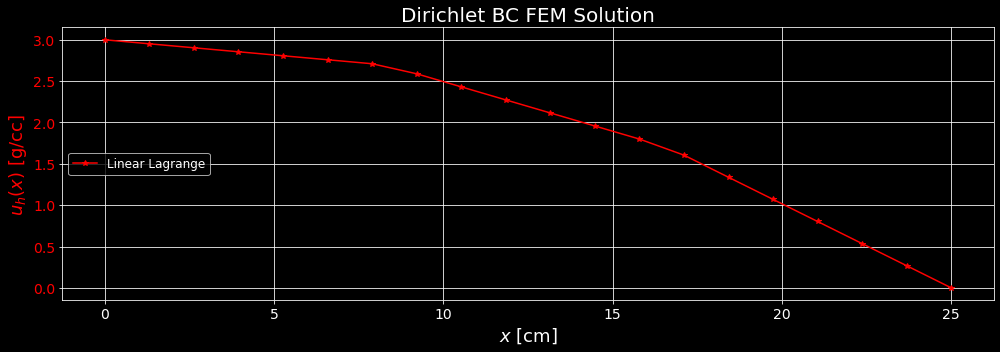

In [12]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_omega_0002.csv')
    
plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Linear Lagrange', flux_basis_functions_type='Constant Monomial')

**Comments:**

1. The *concentration* drops from the entry value to the exit as prescribed by the boundary conditions.
1. Because of the source term the profile is quadratic.
1. Since the linear Lagrange basis functions are used with 3 finite elements, 3 linear sections approximate the solution.
1. The diffusion flux is positive everywhere, $q(x) >0$, since the normal diffusion flux on the left boundary is $q_n(a) := -q(a)$, then there is *feed* on the left boundary. On the right boundary $q_n(b) := q(b) > 0$ and there is *draining* at $x=b$.

### [FEM Error](#toc)<a id="linearerror"></a>

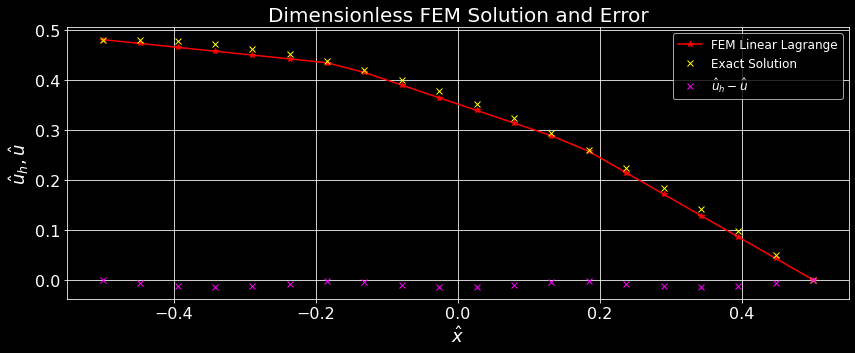

In [13]:
'''Error Compared to Exact Dimensionless Solution'''

plot_solution_error(df, fem_type='FEM Linear Lagrange')

**Comments:**

1. Error as compared to the exact dimensionless solution is zero at the boundary of the linear sections but not in between.
1. Even with linear Lagrange basis functions the error is relatively small proving that the use of basis functions of compact support is attractive.

## [Quadratic Lagrange FEM](#toc)<a id="dbcquadfemresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

The input file needs changes to select the higher order approximation:

```
[Mesh]
 [1d]                                # any lower case name; this is our 1D block
  type = GeneratedMeshGenerator  
  dim = 1 
  xmin = 0 
  xmax = 25
  nx = 1 
  elem_type = edge3                  # this goes with the second order Lagrange basis functions below
 []
[]

[Variables]
 [u]                                 # our unknown variable to be related to below
  order = second                     # MOOSE second order Lagrange basis functions
  family = lagrange
 []
[]
```

In [14]:
'''FEM Solution'''

n_felem = 1

order = 'second'

#n_plot_pts = 2*n_felem + 1
n_plot_pts = 20

In [15]:
'''OLD-FEM Solution'''

#try:    
#    from engy_5310.toolkit import write_engy5310_p1_1d_input_file  
#except ModuleNotFoundError:
#    assert False, 'You need to provide your own code here. Bailing out.'

#write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, u_left=u_a, u_right=u_b, 
#                                diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
#                                n_plot_pts=n_plot_pts)

'OLD-FEM Solution'

In [16]:
'''Write input file'''
write_input_file()

In [17]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

[Problem]
  type = FEProblem
  coord_type = XYZ
[]
[Mesh]
  [omega]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = 0
    xmax = 25
    nx = 1
    elem_type = edge3
  []
[]
[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = 1.5
  []
[]
[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u
    diffCoeff = 0.1
  []
  [source-term]
    type = SourceTerm
    variable = u
    sourceS = 0.001
    coupledVariable = u
  []
[]
[BCs]
  [entry-u]
    type = DirichletBC
    variable = u
    boundary = left
    value = 3
  []
  [exit-u]
    type = DirichletBC
    variable = u
    boundary = right
    value = 0
  []
[]
[Executioner]
  type = Steady
  solve_type = PJFNK
  petsc_options_iname = '-pc_type -pc_hypre_type'
  petsc_options_value = 'hypre boomeramg'
  l_max_its = 20
  l_tol = 1e-05
  nl_max_its = 15
  nl_rel_tol = 1e-08
  nl_abs_tol = 1e-08
[]
[VectorPostprocessors]
  [omega]
    type = LineValueSampler
    execute_on = 'timestep_en

In [18]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit


Framework Information:
MOOSE Version:           git commit 38d37b938c on 2021-10-22
LibMesh Version:         aebb5a5c0e1f6d8cf523a720e19f70a6d17c0236
PETSc Version:           3.16.0
SLEPc Version:           3.16.0
Current Time:            Tue Dec  7 16:04:04 2021
Executable Timestamp:    Tue Dec  7 15:36:00 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   3
  Elems:                   1
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                3
  Num Local DOFs:          3
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Steady
  Solver Mode:             Preconditioned JFNK
  PETSc Preconditioner:    hypre boomeramg 

 0 Nonlinear |R| = 1.666667e-02
      0 Linear |R| = 1.666667e-02
      1 Linear |R| = 

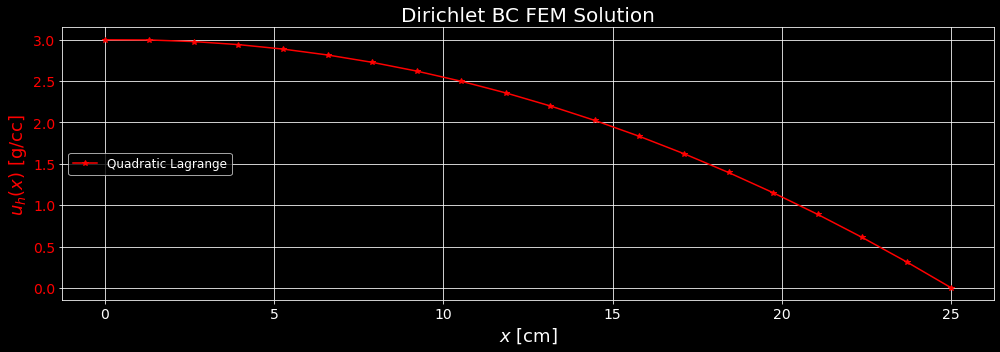

In [19]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_omega_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

### [FEM Error](#toc)<a id="quaderror"></a>


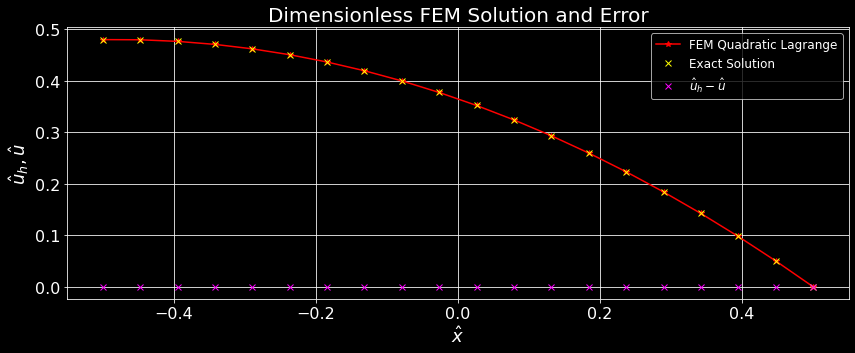

In [20]:
'''Error Compared to Exact Dimensionless Solution'''

plot_solution_error(df, fem_type='FEM Quadratic Lagrange')

**Comments:**

1. Usage of one quadratic Lagrange finite element reproduces the exact solution; as it had to.

## [Diffusion Flux Postprocessing](#toc)<a id="diffusionfluxpostpro"></a>

The diffusion flux is needed in the [Poisson-Dirichlet energy](#energy) integral. This section describes the post-processing operation of calculating the flux $q$ from $u$. There are two ways to postprocess the diffusion flux as described below. In both of them, an auxiliary variable needs to be created.

### [Auxiliary Variable](#toc)<a id="auxvar"></a>

A derived variable for the diffusion flux calculated from the unknown $u$ needs to be specified in the `MOOSE` input file. The shape of the basis functions used for the diffusion flux should be consistent with the choice used for the $u$ variable. For example:

```
[Variables]
  [u]
    order = second
    family = lagrange
  []
[]

[AuxVariables]
  [diffFluxU_x]           # user-named diffusion flux component in x
    order = FIRST
    family = MONOMIAL
  []
[]
```

### [Use `MOOSE` Diffusion Flux Auxiliary Kernel](#toc)<a id="auxdiffflux"></a>

One way to compute the derivative of $u$ is to use the `MOOSE` framework `DiffusionFluxAux` kernel.
It is available for computing the flux $q$ so the flux can be computed directly using the `MOOSE` input file as follows:

```
[AuxKernels]
  [diffusion-flux-x]
    execute_on = timestep_end
    type = DiffusionFluxAux   # MOOSE provided
    diffusivity = ${replace diff_coeff}
    variable = diffFluxU_x
    diffusion_variable = u
    component = x
  []
[]
```

Also, you need to output the values of flux for plotting; just add the newly created auxiliary field to the list of variables (`# output data`) on the `VectorPostprocessors` block output file, that is:

```
[VectorPostprocessors]
  [x-data]
    type = LineValueSampler
    execute_on = 'timestep_end final'
    variable = 'u diffFluxU_x'            # output data
    start_point = '${replace xmin} 0 0'
    end_point = '${replace xmax} 0 0'
    num_points = 20
    sort_by = id
  []
[]
```

In [21]:
'''FEM Solution'''

n_felem = 1

order = 'second'

#n_plot_pts = 2*n_felem + 1
n_plot_pts = 20

In [22]:
'''OLD-Write input file'''

try:    
    from engy_5310.moose_toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, u_left=u_a, u_right=u_b, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts, 
                                compute_diffusion_flux=True, use_moose_diffusion_flux=True)

In [23]:
'''Write input file'''

#write_input_file()

'Write input file'

In [24]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 07Dec21 16:04:05

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
u_left = 3.00000e+00
u_right = 0.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [omega-1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 1
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${fparse (u_right+u_left)/2}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace 

In [25]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit


Framework Information:
MOOSE Version:           git commit 38d37b938c on 2021-10-22
LibMesh Version:         aebb5a5c0e1f6d8cf523a720e19f70a6d17c0236
PETSc Version:           3.16.0
SLEPc Version:           3.16.0
Current Time:            Tue Dec  7 16:04:05 2021
Executable Timestamp:    Tue Dec  7 15:36:00 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   3
  Elems:                   1
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                3
  Num Local DOFs:          3
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                4
  Num Local DOFs:          4
  Variables:               "diffFluxU" "diffFluxU_x" 
  Finite Element Types:    "MONOMIAL_VEC" "MONOMIAL" 
  Approximation Orders:    "FIRST" "FIRST" 

Executi

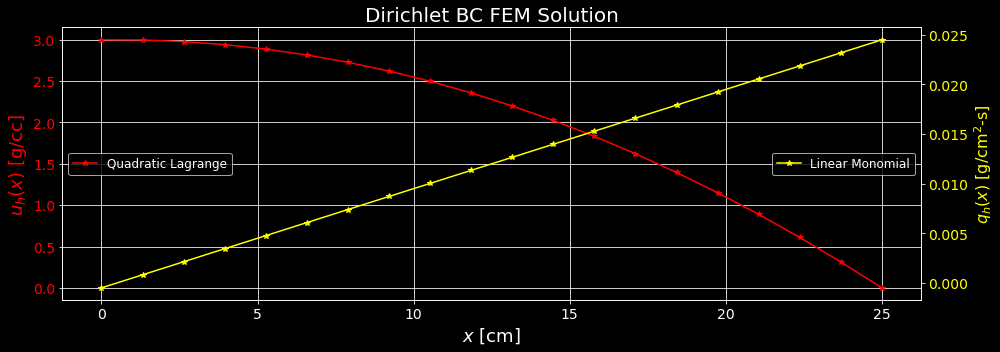

In [26]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_omega-data_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

#### [Compute Error](#toc)<a id="difffluxerror1"></a>


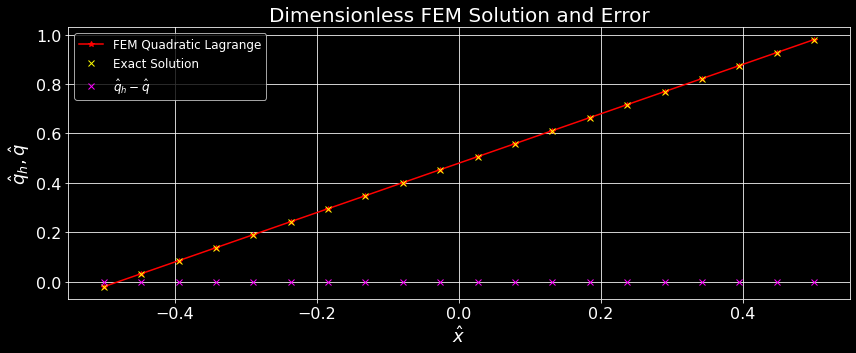

In [27]:
'''Flux Error Compared to Exact Dimensionless Solution'''

plot_flux_error(df, fem_type='FEM Quadratic Lagrange')

### [Code a Diffusion Flux Auxiliary Kernel](#toc)<a id="auxdiffflux2"></a>

An alternative way to compute the flux of $u$ is to program an auxiliary kernel. This is a worthwhile investment for learning how to implement an auxiliary kernel; in the future when the flux is needed as a vector quantity, this learning experience will be leveraged. There are two ways to do this: one, is to postprocess the $x$ component of the flux as done in the `MOOSE` auxiliary kernel. The other way is to postprocess the flux vector. The choice matters because the parent class for the auxiliary kernel is different depending on the returned data type; scalar versus vector.

#### Flux component

1. `cd include`
1. `mkdir auxkernels`
1. `cd auxkernels`
1. Create a `DiffusionFluxComponent.h` class interface as folows:
 + Use the `FluxComponent.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/FluxComponent.h) as follows:
 + `cp *path-to*/moose-app-templates/FluxComponent.h .`
 + `mv FluxComponent.h DiffusionFluxComponent.h`
 + Edit the file `DiffusionFluxComponent.h` with a text editor by replacing all instances of `FluxComponent` with `DiffusionFluxComponent`.
 + Declare member variables in the header files for example:
 ```c++
   /// Will hold 0, 1, or 2 corresponding to x, y, or z.
  int _component;
  /// The gradient of a coupled variable
  const VariableGradient & _gradU;
  /// Add here other parameters needed
  Real _diffCoeff;
 ```
1. `cd ../..`
1. `cd src`
1. `mkdir auxkernels`
1. `cd auxkernels`
1. Create a `DiffusionFluxComponent.C` class implementation as follows:
 + Use the `FluxComponent.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/FluxComponent.C) as follows.
 + `cp *path-to*/moose-app-templates/FluxComponent.C .`
 + `mv FluxComponent.C DiffusionFluxComponent.C`
 + Edit the file `DiffusionFluxComponent.C` with a text editor by replacing all instances of `FluxComponent` with `DiffusionFluxComponent`.
 + You will need to program the *computeValue()* method. <span style="color:red">This portion of the implementation is convered in class.</span> Here is an example of what the method would look like:
```c++
DiffusionFluxComponent::DiffusionFluxComponent(const InputParameters & parameters)
  : AuxKernel(parameters),
    // Initialize the flux component
    _component(getParam<MooseEnum>("component")),
    // Initialize variable gradient
    _gradU(coupledGradient("field")),
    // Initialize parameters
    _diffCoeff(getParam<Real>("diffCoeff"))
{
}
Real
DiffusionFluxComponent::computeValue()
{
  return - _diffCoeff * _gradU[_qp](_component);
}
```
Depending on your implementation, the `MOOSE` input block may look like this:

```
[AuxKernels]
  [diffusion-flux-x]
    execute_on = timestep_end
    type = DiffusionFluxComponent       # user-built auxiliary kernel
    field = u                           # user-defined parameter
    diffCoeff = ${replace diff_coeff}   # user-defined parameter
    component = x                       # user-defined parameter
    variable = diffFluxU_x              # produced quantity
  []
[]
```

#### Flux vector (preferred option)

1. `cd include`
1. `mkdir auxkernels`
1. `cd auxkernels`
1. Create a `DiffusionFlux.h` class interface as folows:
 + Use the `FluxVector.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/FluxVector.h) as follows:
 + `cp *path-to*/moose-app-templates/FluxVector.h .`
 + `mv VectorFlux.h DiffusionFlux.h`
 + Edit the file `DiffusionFlux.h` with a text editor by replacing all instances of `FluxVector` with `DiffusionFlux`.
 + Declare member variables in the header files for example:
 ```c++
  /// The gradient of a coupled variable
  const VariableGradient & _gradU;
  /// Add here other parameters needed
  Real _diffCoeff;
 ```
1. `cd ../..`
1. `cd src`
1. `mkdir auxkernels`
1. `cd auxkernels`
1. Create a `DiffusionFlux.C` class implementation as follows:
 + Use the `FluxVector.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/FluxVector.C) as follows.
 + `cp *path-to*/moose-app-templates/FluxVector.C .`
 + `mv FluxVector.C DiffusionFlux.C`
 + Edit the file `DiffusionFlux.C` with a text editor by replacing all instances of `FluxVector` with `DiffusionFlux`.
 + You will need to program the *computeValue()* method. <span style="color:red">This portion of the implementation is convered in class.</span> Here is an example of what the method would look like:
```c++
DiffusionFlux::DiffusionFlux(const InputParameters & parameters)
  : VectorAuxKernel(parameters),
    // Initialize variable gradient
    _gradU(coupledGradient("field")),
    // Initialize parameters
    _diffCoeff(getParam<Real>("diffCoeff"))
{
}
RealVectorValue
DiffusionFlux::computeValue()
{
  return - _diffCoeff * _gradU[_qp];
}
```

Depending on your implementation, the `MOOSE` input block may look like this:

```
[AuxKernels]
  [diffusion-flux]
    execute_on = timestep_end
    type = DiffusionFlux      # user coded kernel
    field = u
    diffCoeff = ${replace diff_coeff}
    variable = diffFluxU     # produced quantity
  []
  [diffusion-flux-x]
    execute_on = timestep_end
    type = VectorVariableComponentAux    #  MOOSE provided
    variable = diffFluxU_x    # produced quantity
    component = x
    vector_variable = diffFluxU   
  []
[]
```

### [Compile and Link Application](#toc)<a id="compile2"></a>

1. Make sure you are in the problem project directory:
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

In [28]:
'''FEM Solution'''

n_felem = 1

order = 'second'

#n_plot_pts = 2*n_felem + 1
n_plot_pts = 20

try:    
    from engy_5310.moose_toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, u_left=u_a, u_right=u_b, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts, compute_diffusion_flux=True)

In [29]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 07Dec21 16:04:06

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
u_left = 3.00000e+00
u_right = 0.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [omega-1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 1
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${fparse (u_right+u_left)/2}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace 

In [30]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit


Framework Information:
MOOSE Version:           git commit 38d37b938c on 2021-10-22
LibMesh Version:         aebb5a5c0e1f6d8cf523a720e19f70a6d17c0236
PETSc Version:           3.16.0
SLEPc Version:           3.16.0
Current Time:            Tue Dec  7 16:04:06 2021
Executable Timestamp:    Tue Dec  7 15:36:00 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   3
  Elems:                   1
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                3
  Num Local DOFs:          3
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                4
  Num Local DOFs:          4
  Variables:               "diffFluxU" "diffFluxU_x" 
  Finite Element Types:    "MONOMIAL_VEC" "MONOMIAL" 
  Approximation Orders:    "FIRST" "FIRST" 

Executi

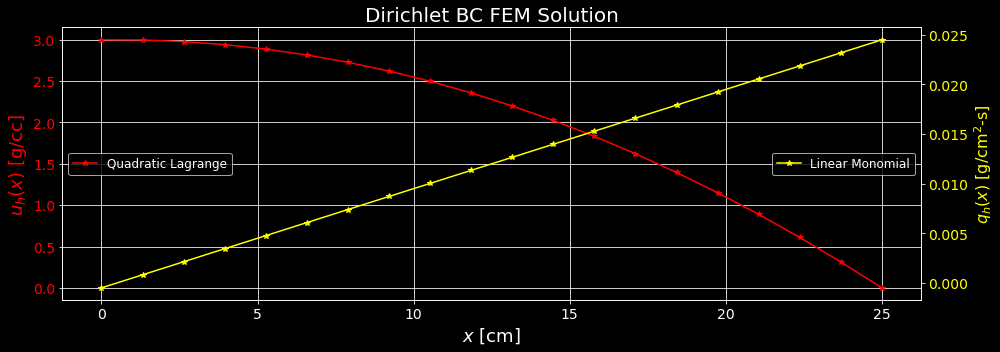

In [31]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_omega-data_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

#### [Compute Error](#toc)<a id="difffluxerror2"></a>

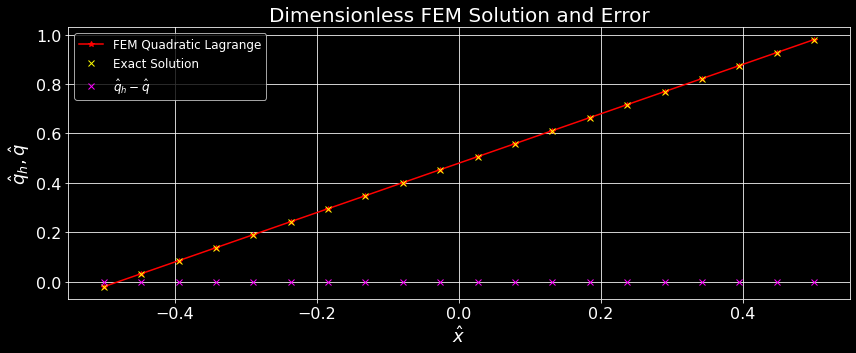

In [32]:
'''Error Compared to Exact Dimensionless Solution'''

plot_flux_error(df, fem_type='FEM Quadratic Lagrange')

## [Energy Postprocessing](#toc)<a id="energypostpro"></a>

To compute the [Poisson-Dirichlet energy](#energy) a *Postprocessor* needs to be built. The user-developed class should use the previously computed diffusion flux component. With an eye towards the future use of this application in 2D and 3D, call this new class, `BulkEnergy`.

### [Code the Energy Postprocessor](#toc)<a id="postpro"></a>

1. `cd include`
1. `mkdir postprocessors`
1. `cd postprocessors`
1. Create a `BulkEnergy.h` class interface as folows:
 + Use the `ScalarVariableIntegralPostprocessor.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/ScalarVariableIntegralPostprocessor.h) as follows:
 + `cp *path-to*/moose-app-templates/ScalarVariableIntegralPostprocessor.h .`
 + `mv ScalarVariableIntegralPostprocessor.h BulkEnergy.h`
 + Edit the file `BulkEnergy.h` with a text editor by replacing all instances of `ScalarVariableIntegralPostprocessor` with `BulkEnergy`.
 + Declare variables in the header file; for example:
 ```c++
  Real _diffCoeff;
  Real _sourceS;
  const VariableValue & _u;
  const VariableValue & _q_i;
 ```
1. `cd ../..`
1. `cd src`
1. `mkdir postprocessors`
1. `cd postprocessors`
1. Create a `BulkEnergy.C` class implementation as follows:
 + Use the `ScalarVariableIntegralPostprocessor.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/ScalarVariableIntegralPostprocessor.C) as follows.
 + `cp *path-to*/moose-app-templates/ScalarVariableIntegralPostprocessor.C .`
 + `mv ScalarVariableIntegralPostprocessor.C BulkEnergy.C`
 + Edit the file `BulkEnergy.C` with a text editor by replacing all instances of `ScalarVariableIntegralPostprocessor` with `BulkEnergy`.
 + You will need to program the *computeValue()* method for the energy:
 \begin{align*}
 \Phi[u] := \int\limits_a^b \,\frac{1}{2}\bigl(q(x)\bigr)^2 - D\,S\,u(x) \,dx.
\end{align*}
See the example below for the input file *Postprocessor* block and the parameters needed. <span style="color:red">This portion of the implementation is convered in class.</span>
For example:
```c++
Real
BulkEnergy::computeQpIntegral()
{
  RealVectorValue q_qp = -_diffCoeff * _gradU[_qp];
  return 1.0/2.0 * q_qp*q_qp - _diffCoeff * _sourceS * _u[_qp]; // q_qp*q_qp dot product
}
```

### [Compile and Link Application](#toc)<a id="compilelink2"></a>

1. Make sure you are in the problem project directory:
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

### [Input File](#toc)<a id="energyinput"></a>

A new *Postprocessors* block should be created; an example follows:

```
[Postprocessors]
  [bulk-energy]
    type = BulkEnergy                                    # user-defined
    execute_on = 'timestep_end final'
    variable = 'u'     # bulk energy unknown variable    # user-defined 
    diffCoeff = ${replace diff_coeff}                    # user-defined
    sourceS = ${replace source_s}                        # user-defined
  []
[]
```

### [Run Application](#toc)<a id="runenergy"></a>

Using an updated input file (see below) run the application as follows:
1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.hit`
2. Compare your results with this notebook results below.
3. Return here to follow instructions on how to implement the calculation of the total energy.

### [Energy Results](#toc)<a id="energyresults"></a>

In [33]:
'''FEM Solution'''

n_felem = 1

order = 'second'

#n_plot_pts = 2*n_felem + 1
n_plot_pts = 20

try:    
    from engy_5310.moose_toolkit import write_engy5310_p1_1d_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_p1_1d_input_file(x_left=x_a, x_right=x_b, u_left=u_a, u_right=u_b, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem=n_felem, order=order, 
                                n_plot_pts=n_plot_pts, compute_energy=True)

In [34]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 07Dec21 16:04:07

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
u_left = 3.00000e+00
u_right = 0.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [omega-1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 1
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${fparse (u_right+u_left)/2}
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}
    coupledVariable = u
  []
[]

[BCs]
  [entry-u]
    type = DirichletBC
    variable = u
    boundary = left
    value = ${replace 

In [35]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit


Framework Information:
MOOSE Version:           git commit 38d37b938c on 2021-10-22
LibMesh Version:         aebb5a5c0e1f6d8cf523a720e19f70a6d17c0236
PETSc Version:           3.16.0
SLEPc Version:           3.16.0
Current Time:            Tue Dec  7 16:04:07 2021
Executable Timestamp:    Tue Dec  7 15:36:00 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   3
  Elems:                   1
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                3
  Num Local DOFs:          3
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Steady
  Solver Mode:             Preconditioned JFNK
  PETSc Preconditioner:    hypre boomeramg 


Postprocessor Values:
+----------------+----------------+
| time           | bulk-ener

#### [Compute Error](#toc)<a id="energyerror"></a>

In [36]:
import pandas as pd
df = pd.read_csv('output_energy.csv')

fem_energy = df['bulk-energy'][0]

L = x_length

fem_energy_hat = fem_energy/source_s**2/L**3
print('FEM energy   [] = %10.6e'%(fem_energy_hat))

try:    
    from engy_5310.moose_toolkit import engy5310_p1_exact_solution  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

(_, _, energy_hat) = engy5310_p1_exact_solution(x_a, x_b, u_a, u_b, diff_coeff, source_s)

print('Exact energy [] = %10.6e'%(energy_hat))

print('Energy rel. error [%%] = %10.3e'%((fem_energy_hat-energy_hat)/energy_hat*100))

FEM energy   [] = -1.664667e-01
Exact energy [] = -1.664667e-01
Energy rel. error [%] =  1.301e-12


## [Application Tree](#toc)<a id="tree"></a>

This tree printout helps the understanding of various pieces of the `MOOSE` application repository created after all the above steps including future implementations in the notebooks following the present one that cover various boundary conditions.

In [37]:
!tree engy5310p1

engy5310p1
├── 2d-rectangle-quad4mesh.e
├── 2d-rectangle-quad9mesh.e
├── 2d-rectangle-tri3mesh.e
├── 2d-rectangle-tri6mesh.e
├── Makefile
├── __pycache__
│   └── chigger.cpython-38.pyc
├── build
│   ├── header_symlinks
│   │   ├── BoundaryEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-09-12-fall/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BoundaryEnergy.h
│   │   ├── BulkEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-09-12-fall/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BulkEnergy.h
│   │   ├── ConvectionTerm.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-09-12-fall/jupynb-repo/notebooks/engy5310p1/include/kernels/ConvectionTerm.h
│   │   ├── DiffusionFlux.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-09-12-fall/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFlux.h
│   │   ├── DiffusionFluxComponent.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-09-12-fall/jupynb-repo/notebooks/engy5